# Training CSPup GAN on CelebA dataset

In [2]:
import os

import numpy as np
import torchvision
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import Dataset

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200


In [3]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda")
GLR = 2e-4  # generator lr
DLR = 2e-5  # discriminator lr
EPOCHES = 50
NDF = 128  # generator feature map size
NC = 3  # color channels
NZ = 100  # latent space dim

CELEBA_DIR = "img_align_celeba"
WEIGHTS_DIR = "weights"
IMGS_DIR = "res"

os.makedirs(IMGS_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)

## Models implementation

### CSPup block implementation (with some mods)

In [4]:
class Block(nn.Module):
    def __init__(self, ch, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size, stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch)  # mod
        self.act = nn.Tanh()  # mod

    def forward(self, x):
        y = self.conv(x)
        y = self.bn(y)
        return self.act(y)


class CSPup(nn.Module):
    def __init__(
        self, c_in, kernel=3, stride=1, pad=1, e=0.5
    ):  # ch_in, ch_out, shortcut, groups, expansion
        super(CSPup, self).__init__()
        self.e = e
        c_out = int(c_in * self.e)

        self.upsamp = nn.ConvTranspose2d(
            c_out, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv1 = Block(c_out, kernel_size=kernel, stride=1, padding=pad)
        self.upsamp1 = nn.ConvTranspose2d(
            c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.conv2 = Block(c_out, kernel_size=kernel, stride=1)
        self.conv3 = nn.Conv2d(
            c_out, c_out, kernel_size=kernel, stride=stride, padding=pad
        )

    def forward(self, x):
        ch = x.shape[1]
        e = int(ch * self.e)
        
        y1 = self.upsamp(x[:, :e, ...])

        y2 = self.conv1(x[:, e:, ...])
        y2 = self.upsamp(y2)
        y2 = self.conv2(y2)
        y2 = self.conv3(y2)

        return y1 + y2

### ~~almost~~ baseline generator implementaion

In [5]:
class GAN_Generator(nn.Module):
    def __init__(self):
        super(GAN_Generator, self).__init__()

        self.n_blocks = 5  # baseline
        self.input_shape = 1024  # baseline

        self.ups = nn.ConvTranspose2d(NZ, self.input_shape, 4, 1, 0)
        self.csp_stack = nn.Sequential(
            *[CSPup(int(self.input_shape / 2**i)) for i in range(self.n_blocks)]
        )
        in_channels = int(self.input_shape / 2 ** (self.n_blocks))
        out_channels = 3
        self.deconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=1
        )
        self.activ = nn.Tanh()

    def forward(self, inputs):
        inputs = self.ups(inputs)
        inputs = self.csp_stack(inputs)
        inputs = self.activ(self.deconv(inputs))

        return inputs

### Default DC generator implementation (just for comparison)

In [ ]:
class DC_Generator(nn.Module):
    def __init__(self):
        super(DC_Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(NZ, NDF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(NDF * 8, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(NDF * 4, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(NDF * 2, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(NDF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class GAN_Discriminator(nn.Module):
    def __init__(self):
        super(GAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # disable this if you work with 64hw images
            nn.Conv2d(NDF * 8, NDF * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # swap this if you work with 64hw images
            nn.Conv2d(NDF * 16, 1, 4, 1, 0, bias=False),
            # nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False), 
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

## Data preparation

In [9]:
class celebaLoader(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dir = dataset_dir
        self.transform = transform
        self.imgs = self.__load()

    def __load(self):
        if not os.path.exists(self.dir):
            raise OSError("No such dataset")
        
        return [os.path.join(self.dir, el) for el in os.listdir(self.dir)]
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = torchvision.io.read_image(self.imgs[idx]) - 127.5
        if self.transform:
            img = self.transform(img)

        return img / 127.5


dataset = celebaLoader(CELEBA_DIR, torchvision.transforms.Resize((NDF, NDF)))
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

## Models init and training

### Initiating models with tricky weights assignement

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# G_model = DC_Generator().to(device)
G_model = GAN_Generator().to(DEVICE)
G_model.apply(weights_init)

D_model = GAN_Discriminator().to(DEVICE)
D_model.apply(weights_init)

GAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negativ

### Initiating loss and optimizer with different lr's and beta1=0.5

In [11]:
criterion = nn.BCELoss()
real_label = 1.0
fake_label = 0.0

beta1 = 0.5
D_optim = optim.Adam(D_model.parameters(), lr=DLR, betas=(beta1, 0.999))
G_optim = optim.Adam(G_model.parameters(), lr=GLR, betas=(beta1, 0.999))

In [12]:
writer = SummaryWriter()

### Train loop

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(EPOCHES):
    for i, batch in enumerate(tqdm(dataloader), 0):
        D_model.zero_grad()

        real_cpu = batch.to(DEVICE)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=DEVICE)

        output = D_model(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, NZ, 1, 1, device=DEVICE)
        fake = G_model(noise)
        label.fill_(fake_label)
        
        output = D_model(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        D_optim.step()

        G_model.zero_grad()
        label.fill_(real_label) 
        output = D_model(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()

        errD = errD.cpu().detach().item()
        errG = errG.cpu().detach().item()
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    EPOCHES,
                    i,
                    len(dataloader),
                    errD,
                    errG,
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

            img = fake[0].permute(1, 2, 0).cpu().detach().numpy()
            plt.imshow(img)
            plt.savefig(os.path.join(IMGS_DIR, f"{epoch}_{i}.png"))

            writer.add_scalars(
                "loss/train/", {"generator_loss": errG, "discriminator_loss": errD}, iters
            )
            writer.add_scalars(
                "misc/train/", {"D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2}, iters
            )
            iters += 50
        
        G_losses.append(errG)
        D_losses.append(errD)

    gm = np.mean(G_losses)

    torch.save(G_model.state_dict(), os.path.join(WEIGHTS_DIR, f"{epoch}_{np.round(gm, 2)}.pt"))
    print(f"epoch: {epoch}  G_loss: {gm}  D_loss: {np.mean(D_losses)}")

    G_losses.clear()
    D_losses.clear()

## Let's look on some generated faces!

In [43]:
G_model = GAN_Generator().to(DEVICE)
G_model.load_state_dict(torch.load("weights/20_1.06.pt"))
G_model.eval()

GAN_Generator(
  (ups): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (csp_stack): Sequential(
    (0): CSPup(
      (upsamp): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (conv1): Block(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Tanh()
      )
      (upsamp1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Block(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): Tanh()
      )
      (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): CSPup(
      (upsamp): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride

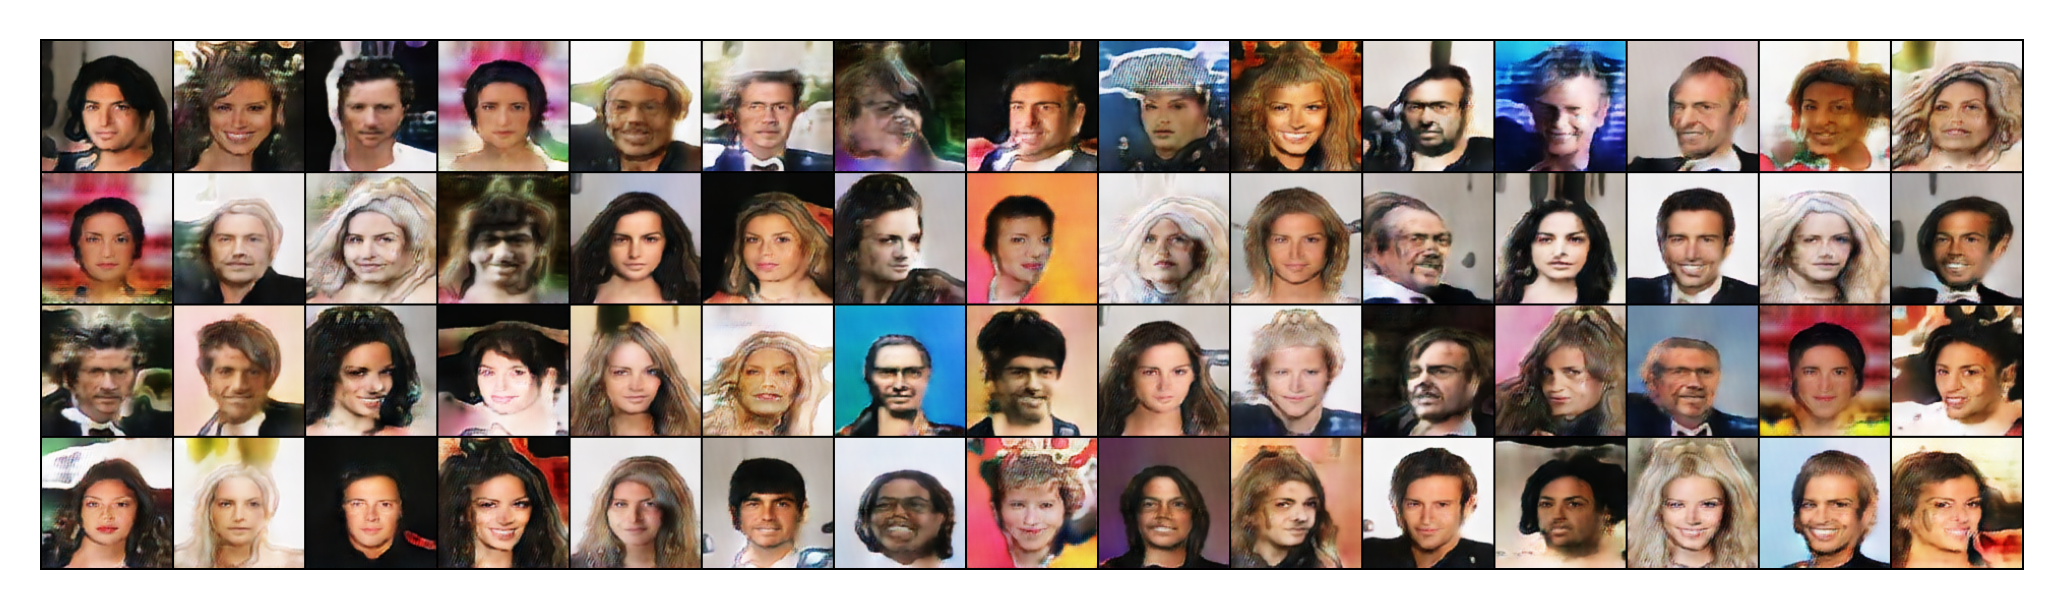

In [44]:
noise = torch.randn(60, NZ, 1, 1, device=DEVICE)
with torch.no_grad():
    fake = G_model(noise).detach().cpu()
    
plt.axis('off')
plt.rcParams['figure.dpi'] = 400
gr = torchvision.utils.make_grid(fake, nrow=15, normalize=True)
plt.imshow(gr.permute(1, 2, 0))